# **Language modeling and Sentiment analysis with Neural Networks**

In [0]:
from fastai import *
from fastai.text import *

In [0]:
bs = 24

## **Preparing the data**

We'll use a dataset created by Andrew Maas which contains 100.000 reviews on IMBD. We have 25000 of those for training, another 25000 for testing and the remaining 50000 are unlabelled.

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

In [0]:
data_lm = TextDataBunch.from_csv(path,'texts.csv')

By executing a single line of code we did a few things. A text is composed of words, so we can feed a NN with them directly. Before that we need to convert them to numbers. This process is done in two steps: tokenization and numerization. Luckily for us, TextDataBunch does all of this for us.

We can check the results of that process.

In [6]:
data_lm.train_ds[0][0]

Text xxbos xxmaj movie had some good acting and good moments ( though obviously pretty low budget ) , but bad rating due to basic premise being badly developed . xxmaj the main point of conflict between the two leads does n't play out in a realistic manner at all . xxmaj there are a few scenes where they disagree because of it , but no discussions of any great depth that would explain how they can be together while seeing the world so differently , especially since the xxunk of xxmaj glenn is so wound up in this part of his life ( and xxmaj adam is active enough with his that he supports it with time and money . ) xxmaj also , several times xxmaj glenn is portrayed xxunk for being the way he is ( apologizing to xxmaj adam for his past ) while xxmaj adam is shown to be xxunk and " traditional , " which the film xxunk to be the " good " way in the end . i do n't like being preached to like that . i attended a discussion session with the director after viewing xxup xxunk , and he said tha

In [7]:
data_lm.train_ds[0][0].data[:10]

array([  2,   5,  28,  85,  62,  70, 123,  12,  70, 401])

## **Language model**

In [8]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/unsup')]

In [9]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat')]

### **Creating the TextLMDataBunch**

This is an alterantive to TextDataBunch. You can use whichever you prefer.

In [0]:
data_lm = (TextList.from_folder(path)
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1, seed=42)
           #We randomly split and keep 10% for validation
            .label_for_lm().databunch(bs=bs, num_workers=1))

A few examples.

In [12]:
data_lm.show_batch()

idx,text
0,"that parade across the screen , the fact that these characters are impossible to identify with had me looking at my watch a mere 20 minutes into the film ( and more than once after that ) . xxmaj the plot development is disjointed and slow , the verbal diarrhoea of the main character 's only friend is practically insufferable , the base quality of most of the characters actions"
1,"that xxmaj terry / xxmaj morgan had been employed as his secretary for three weeks . xxmaj why exactly was that ? xxmaj after the fact it would make sense that she was there for a newspaper story , but before ? xxmaj clues are dropped regarding xxmaj harker 's association with a known mobster conveniently living in the same apartment building , but again , that association is n't"
2,"centered in the frame . xxmaj on the other hand , xxmaj angie xxmaj harmon has very nice nostrils and left ear . \n \n xxmaj the only real surprise in the movie is the big names they convinced to do it . xxmaj when you consider this movie was never released in theaters despite having an all - star cast , you might be inclined to think something"
3,"worth waiting for the film to develop . \n \n xxmaj if anyone does know whether the meeting of 1976 really did happen please send it to the ' comments page ' for this film , i 'd be very interested . xxbos xxmaj sure this was a remake of a 70 's film , but it had the suspense and action of a current film , say xxmaj"
4,"dolls , which was not only trashy but boring as well . xxmaj at least this was n't boring . \n \n xxmaj pia gets naked a lot and seems miscast as a writer . xxmaj watching her talk about xxmaj xxunk and xxmaj byron with a guy three times her age is flat unbelievable . i 'm sure xxmaj pia 's a nice person in real life ,"


In [0]:
data_lm.save('lm_databunch')

### **Loading saved data and creating language model**

In [0]:
data_lm = load_data(path, 'lm_databunch', bs=bs)

In [0]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [0]:
awd = learn_lm.model[0]

In [0]:
from scipy.spatial.distance import cosine as dist

In [0]:
enc = learn_lm.model[0].encoder

In [20]:
enc.weight.size()

torch.Size([60000, 400])

### **Generating fake movie reviews**

In [0]:
TEXT = "The color of the sky is"
N_WORDS = 40
N_SENTENCES = 2

In [22]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The color of the sky is English , meaning Scottish or Dutch Island or Danish Chance . This is exemplified by the popular use of colour as the main backdrop , and the colour of the flame , which
The color of the sky is inspired by the red , yellow and green sky of the Old Christian Church . The term " red sky " was used in the film The Fly . In the episode "


In [0]:
TEXT = "I hated this movie"
N_WORDS = 30
N_SENTENCES = 2

In [24]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie . The idea of it having a " guy who can ' t even make a mistake " is a reference to the Bible , a book in
I hated this movie in France and in 1 May 2002 , French director Pierre de Gaulle stated that he had to sign a French spy film to


We can make text less randomized by reducing the temperature.

In [26]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.1) for _ in range(N_SENTENCES)))

I hated this movie by John Lennon , and he said , " It 's a great thing to do . It 's a great thing to do . "
I hated this movie by John Lennon , and it was the first film to be released in the United States . The film was released in North


### **Training the model**

This part remains the same as always.

In [27]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


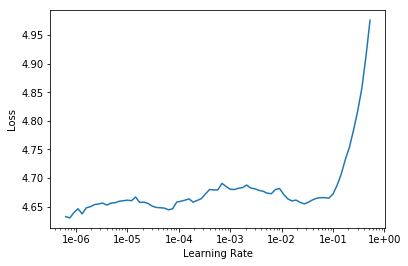

In [28]:
learn_lm.recorder.plot(skip_end=15)

In [0]:
lr = 1e-3
lr *= bs/48

In [0]:
learn_lm.to_fp16();

In [31]:
learn_lm.fit_one_cycle(1, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored

In [0]:
learn_lm.save('fit_1')

In [0]:
learn_lm.load('fit_1');

In [34]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored

In [0]:
learn_lm.save('fine_tuned')
learn_lm.save_encoder('fine_tuned_enc')

### **Generating more reviews**

In [0]:
learn_lm.load('fine_tuned');

In [0]:
TEXT = "I think this movie"
N_WORDS = 40
N_SENTENCES = 2

In [38]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I think this movie is in the process of making a world station , but it was not the same . The dialogue is not the same as it has on the TV . Us are lots of people , not
I think this movie is technically a great movie . The fact that i love it is at least part of an reality movie . i do n't recommend it . i 'm sorry i ca n't even know . i have never


In [0]:
TEXT = "The movie"
N_WORDS = 30
N_SENTENCES = 2

In [40]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The movie is one of the worst films of all time , especially when the European version is about American Civil War judaism , which is not
The movie is an excellent one with a story that is beautifully filmed and cast . The casting , although cast , is poorly done and is poorly acted .


## **Classifier**

In [0]:
bs = 24

In [0]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs, num_workers=1))

In [0]:
data_clas.save('imdb_textlist_class')

In [0]:
data_clas = load_data(path, 'imdb_textlist_class', bs=bs, num_workers=1)

In [45]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj by now you 've probably heard a bit about the new xxmaj disney dub of xxmaj miyazaki 's classic film , xxmaj laputa : xxmaj castle xxmaj in xxmaj the xxmaj sky . xxmaj during late summer of 1998 , xxmaj disney released "" xxmaj kiki 's xxmaj delivery xxmaj service "" on video which included a preview of the xxmaj laputa dub saying it was due out",pos
"xxbos xxmaj although in my opinion this is one of the lesser musicals of stars xxmaj frank xxmaj sinatra , xxmaj gene xxmaj kelly , xxmaj kathryn xxmaj grayson and director xxmaj george xxmaj sidney , a lesser musical featuring anyone from that line - up is nothing to sneeze at , and in conjunction , the line - up makes xxmaj anchors xxmaj aweigh a pretty good film despite",pos
"xxbos xxmaj retitled from its original xxmaj japanese name of xxup laputa ( for being an offensive phrase , something which director xxmaj hayao xxmaj miyazaki was oblivious to at the time ) , xxup castle xxup in xxup the xxup sky is the master animator 's third film , and it 's one of his most beloved of all time . xxmaj initially a box office disappointment in its",pos
"xxbos xxmaj back in 1997 , do i remember that year : xxmaj clinton bans cloning research , the unfortunate death of xxmaj princess xxmaj diana , the xxmaj xxunk won the world series and a woman gave birth to xxunk . xxmaj this was also the big year in the release of xxmaj titanic , one of the biggest films of all time : a tale about the ship",pos


In [0]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3) #.to_fp16()
learn_c.load_encoder('fine_tuned_enc')
learn_c.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


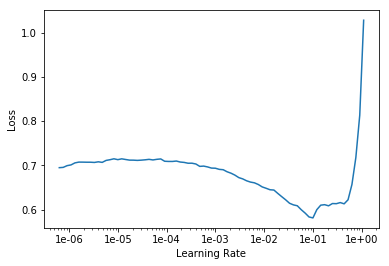

In [47]:
learn_c.lr_find()
learn_c.recorder.plot()

In [48]:
learn_c.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored

In [0]:
learn_c.save('first')
learn_c.load('first');

In [50]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: ignored

In [0]:
learn_c.save('2nd')

In [0]:
learn_c.save('clas')

In [55]:
learn_c.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([6.1445e-06, 9.9999e-01]))

In [56]:
learn_c.predict("I didn't really love that movie, and I didn't think it was awesome.")

(Category neg, tensor(0), tensor([0.8833, 0.1167]))